In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os  # Importar os para manejar directorios
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

C:\Users\willy\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ARIMA
## Modelo de Predicción de Series de Tiempo de Delitos Informáticos

## Preprocesamiento

Carga de los datos, definición de carpetas para guardar resultados (tablas e imágenes) y creación del dataframe.

In [2]:
# Ruta para guardar las tablas
output_folder = 'C:/Users/willy/anaconda3/TFM/Arima'
os.makedirs(output_folder, exist_ok=True)

# Cargar el archivo Excel
file_path = 'C:/Users/willy/anaconda3/TFM/DI_2019_2024.xlsx'
xls = pd.ExcelFile(file_path)
data = pd.read_excel(xls, sheet_name='Hoja1')

# Crear un DataFrame con solo los campos 'departamento_hecho', 'fecha_hecho' y 'delito_agrupado'
df = data[['departamento_hecho', 'fecha_hecho', 'delito_agrupado']]

# Añadir una nueva columna 'categoria_delito' basada en las condiciones especificadas
df['categoria_delito'] = df['delito_agrupado'].apply(lambda x: 1 if x in ['Hurto por medios informáticos', 'Transferencia no consentida'] else 0)

# Asegurarse de que 'fecha_hecho' es de tipo datetime
df['fecha_hecho'] = pd.to_datetime(df['fecha_hecho'])

# Establecer 'fecha_hecho' como índice
df.set_index('fecha_hecho', inplace=True)

## Definición de funciones

In [3]:
# Función para evaluar la estacionalidad
def has_seasonality(series, period=52, threshold=0.1):
    stl = STL(series, period=period)
    result = stl.fit()
    seasonal = result.seasonal
    return np.std(seasonal) > threshold * np.std(series)

# Función para calcular la distancia Hellinger
def hellinger_distance(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)

# RMSLE
def rmsle_fun(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))
    
# Función para calcular métricas: RMSE, MAE y Distancia Hellinger
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = mean_absolute_error(y_true, y_pred)
    rmsle = rmsle_fun(y_true, y_pred)
    hellinger = hellinger_distance(y_true, y_pred)
    
    # Normalizar las distribuciones
    y_true_sum = np.sum(y_true)
    y_pred_sum = np.sum(y_pred)
    
    if y_true_sum == 0 or y_pred_sum == 0:
        hellinger = np.nan
    else:
        p = y_true / y_true_sum
        q = y_pred / y_pred_sum
        hellinger = (1.0 / np.sqrt(2)) * np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))
    
    return {'RMSE': rmse, 'MAE': mae, 'RMSLE': rmsle, 'Distancia Hellinger': hellinger}

## Función principal para procesar las series de tiempo de todos los departamentos por categoría de delito

In [4]:
# Función para procesar datos por categoría
def process_category(df_filtered, categoria_delito, title, filename_prefix, threshold=0.1):
    # Contar el número de registros por departamento
    departamento_counts = df_filtered['departamento_hecho'].value_counts()

    # Ordenar los departamentos en orden descendente según el número de registros
    departamentos = departamento_counts.index

    resultados_df1 = []
    resultados_df2 = []

    # Crear subplots
    num_departamentos = len(departamentos)
    num_cols = 2
    num_rows = (num_departamentos + num_cols - 1) // num_cols  # Calcular el número de filas necesario
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows), constrained_layout=True)
    
    # Ajustar los tamaños de los títulos y etiquetas
    title_fontsize = 16 + 2  # Incremento de 2 puntos en el tamaño del título
    label_fontsize = 12 + 2  # Incremento de 2 puntos en el tamaño de las etiquetas

    fig.suptitle(title, fontsize=title_fontsize)
    
    # Asegurarse de que axes es un array 2D
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.reshape(num_rows, num_cols)

    # Iterar sobre cada departamento
    for i, departamento in enumerate(departamentos):
        print(f'Procesando departamento: {departamento}...')  # Mensaje de progreso
        start_time = time.time()  # Inicio de la medición del tiempo

        # Filtrar los datos para el departamento actual
        df_depto = df_filtered[df_filtered['departamento_hecho'] == departamento]
        
        # Resamplear los datos a frecuencia semanal, sumando la cantidad de casos
        df_week = df_depto.resample('W-SUN').size().reset_index(name='Casos')
        df_week.set_index('fecha_hecho', inplace=True)
        
        # Dividir los datos en conjuntos de entrenamiento (2019-2023) y prueba (2024)
        train = df_week[df_week.index.year < 2024]
        test = df_week[df_week.index.year == 2024]

        # Realizar el test de Dickey-Fuller
        dftest = adfuller(train['Casos'])
        p_value = dftest[1]
        test_statistic = dftest[0]
        critical_value_5 = dftest[4]['5%']
        if p_value < 0.05:
            tipo_serie = 'Estacionaria'
        else:
            tipo_serie = 'No estacionaria'
        
        # Evaluar estacionalidad
        period = 52  # Se puede ajustar el período si es necesario
        if has_seasonality(train['Casos'], period=period, threshold=threshold):
            # Identificar el mejor modelo SARIMA con auto_arima
            model_auto = pm.auto_arima(train['Casos'], start_p=1, max_p=5, start_q=1, max_q=5,
                                       test='adf', max_d=2, max_D=1,
                                       m=period, seasonal=True, trace=False,
                                       error_action='ignore', suppress_warnings=True, stepwise=True)
            best_order = model_auto.order
            best_seasonal_order = model_auto.seasonal_order
            best_model = f'SARIMA{best_order}{best_seasonal_order}'
            model = SARIMAX(train['Casos'], order=best_order, seasonal_order=best_seasonal_order)
        else:
            # Identificar el mejor modelo ARIMA con auto_arima
            model_auto = pm.auto_arima(train['Casos'], start_p=1, max_p=5, start_q=1, max_q=5,
                                       test='adf', max_d=2,
                                       m=1, seasonal=False, trace=False,
                                       error_action='ignore', suppress_warnings=True, stepwise=True)
            best_order = model_auto.order
            best_model = f'ARIMA{best_order}'
            model = ARIMA(train['Casos'], order=best_order)
        
        model_fit = model.fit()
        end_time = time.time()  # Fin de la medición del tiempo
        training_time = end_time - start_time  # Tiempo de entrenamiento

        # Realizar predicciones
        horizon = len(test)  # Horizonte de predicción (tamaño de conjunto de prueba)
        forecast = model_fit.get_forecast(steps=horizon)
        fc = forecast.predicted_mean
        conf = forecast.conf_int()
        
        # Evaluar la predicción
        mean_df = df_week['Casos'].mean()
        metrics = calculate_metrics(test['Casos'].values, fc.values)
        rmse = metrics['RMSE']
        mae = metrics['MAE']
        rmsle = metrics['RMSLE']
        hellinger = metrics['Distancia Hellinger']

        # Guardar los resultados en las listas
        resultados_df1.append([departamento, p_value, test_statistic, critical_value_5, tipo_serie, best_model])
        resultados_df2.append([departamento, mean_df, rmse, mae, rmsle, hellinger, training_time])

        # Graficar los resultados en el subplot correspondiente
        row = i // num_cols
        col = i % num_cols
        axes[row, col].plot(train.index, train['Casos'], label='Entrenamiento', color='tab:blue', lw=1.5)
        axes[row, col].plot(test.index, test['Casos'], label='Prueba', color='tab:orange', lw=1.5)
        axes[row, col].plot(fc.index, fc, label='Predicción', color='tab:green', lw=1.5)
        
        # Ajustar el título
        axes[row, col].set_title(departamento, fontsize=title_fontsize, pad=10)
        
        # Etiquetas
        axes[row, col].set_ylabel('Cantidad de Casos', fontsize=label_fontsize)
        axes[row, col].set_xlabel('Año', fontsize=label_fontsize)
        
        # Ajustar el tamaño de los ticks
        axes[row, col].tick_params(axis='both', labelsize=label_fontsize)
        axes[row, col].legend(loc='upper left', fontsize=10)

    # Eliminar subplots vacíos si los hay
    total_subplots = num_rows * num_cols
    if num_departamentos < total_subplots:
        for j in range(num_departamentos, total_subplots):
            fig.delaxes(axes.flatten()[j])

    # Guardar la gráfica
    plt.savefig(f'{output_folder}/{filename_prefix}_grafica.png')
    plt.show()
  
    # Crear DataFrames con los resultados
    resultados_df1 = pd.DataFrame(resultados_df1, columns=['Departamento', 'p-valor', 'Test Statistic', 'Critical Value (5%)', 'Tipo de Serie Identificada', 'Mejor Modelo'])
    resultados_df2 = pd.DataFrame(resultados_df2, columns=['Departamento', 'Media', 'RMSE', 'MAE', 'RMSLE', 'Distancia Hellinger', 'Tiempo de entrenamiento'])
    
   # Formatear valores flotantes a 5 dígitos decimales
    resultados_df1[['p-valor', 'Test Statistic', 'Critical Value (5%)']] = resultados_df1[['p-valor', 'Test Statistic', 'Critical Value (5%)']].applymap(lambda x: f'{x:.5f}')
    resultados_df2[['RMSE', 'MAE', 'RMSLE', 'Distancia Hellinger']] = resultados_df2[['RMSE', 'MAE', 'RMSLE', 'Distancia Hellinger']].applymap(lambda x: f'{x:.5f}' if not pd.isna(x) else 'NaN')

    # Mostrar DataFrames
    print(resultados_df1)
    print(resultados_df2)

    # Guardar las tablas en un archivo Excel en hojas separadas
    excel_path = os.path.join(output_folder, f'{filename_prefix}_resultados.xlsx')
    with pd.ExcelWriter(excel_path) as writer:
        resultados_df1.to_excel(writer, sheet_name='Resumen_Modelos', index=False)
        resultados_df2.to_excel(writer, sheet_name='Metricas', index=False)
    print(f'Tablas guardadas en {excel_path}')

## Procesamiento de datos 'categoria_delito' = 0, 
## 'Atentados contra la confidencialidad, la integridad y la disponibilidad de los datos y de SI'

Procesando departamento: Bogotá DC...
Procesando departamento: Antioquia...
Procesando departamento: Cundinamarca...
Procesando departamento: Valle del Cauca...
Procesando departamento: Atlántico...
Procesando departamento: Santander...
Procesando departamento: Tolima...
Procesando departamento: Norte de Santander...
Procesando departamento: Bolívar...
Procesando departamento: Risaralda...


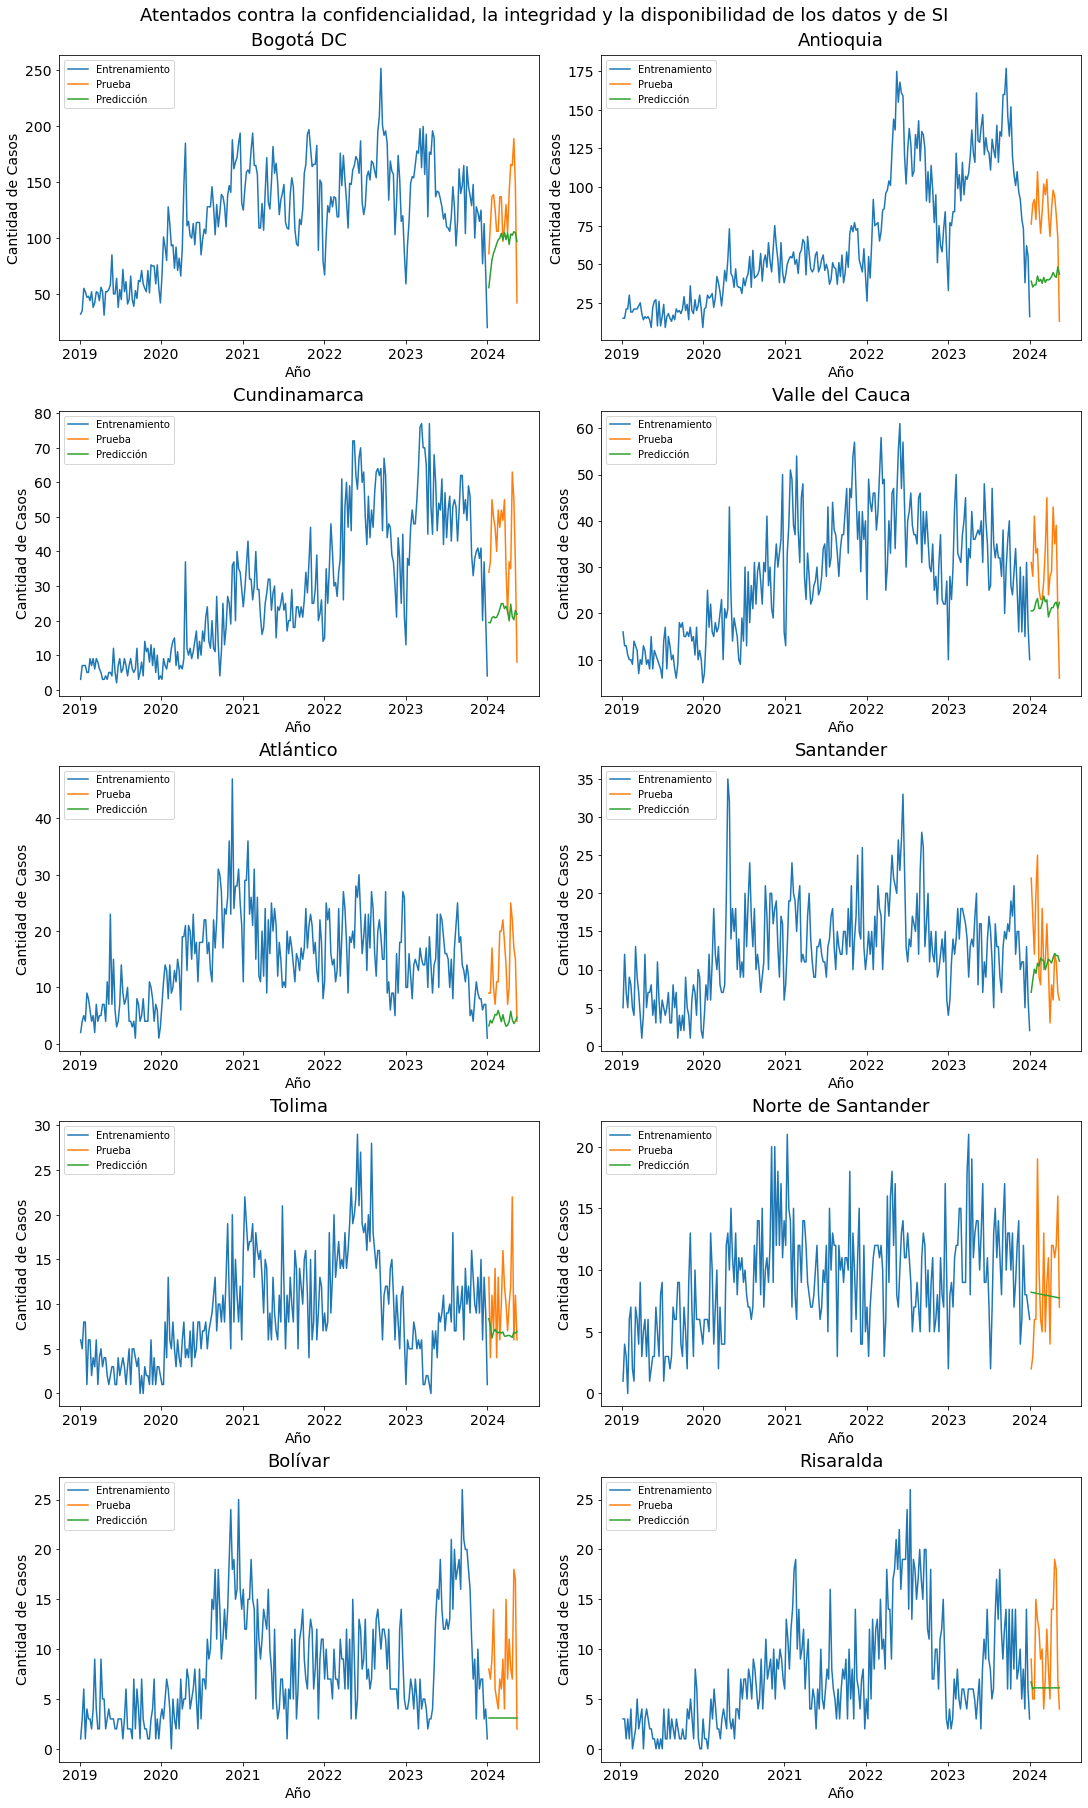

         Departamento  p-valor Test Statistic Critical Value (5%)  \
0           Bogotá DC  0.03471       -3.00197            -2.87281   
1           Antioquia  0.35713       -1.84753            -2.87290   
2        Cundinamarca  0.32026       -1.92530            -2.87281   
3     Valle del Cauca  0.25127       -2.08333            -2.87294   
4           Atlántico  0.32349       -1.91832            -2.87308   
5           Santander  0.00021       -4.48395            -2.87281   
6              Tolima  0.18054       -2.27385            -2.87285   
7  Norte de Santander  0.12451       -2.46389            -2.87312   
8             Bolívar  0.04792       -2.87838            -2.87285   
9           Risaralda  0.10866       -2.52865            -2.87290   

  Tipo de Serie Identificada                  Mejor Modelo  
0               Estacionaria  SARIMA(1, 1, 2)(0, 0, 1, 52)  
1            No estacionaria  SARIMA(0, 1, 2)(1, 0, 0, 52)  
2            No estacionaria  SARIMA(0, 1, 1)(0, 0, 1, 52

In [5]:
# Procesar datos de 'categoria_delito' = 0
df_filtered_0 = df[df['categoria_delito'] == 0]
process_category(df_filtered_0, 0, 'Atentados contra la confidencialidad, la integridad y la disponibilidad de los datos y de SI', 'categoria_0')

## Procesamiento de datos 'categoria_delito' = 1,
## 'Atentados informáticos y otras infracciones'

Procesando departamento: Bogotá DC...
Procesando departamento: Antioquia...
Procesando departamento: Valle del Cauca...
Procesando departamento: Cundinamarca...
Procesando departamento: Santander...
Procesando departamento: Atlántico...
Procesando departamento: Tolima...
Procesando departamento: Bolívar...
Procesando departamento: Risaralda...
Procesando departamento: Norte de Santander...


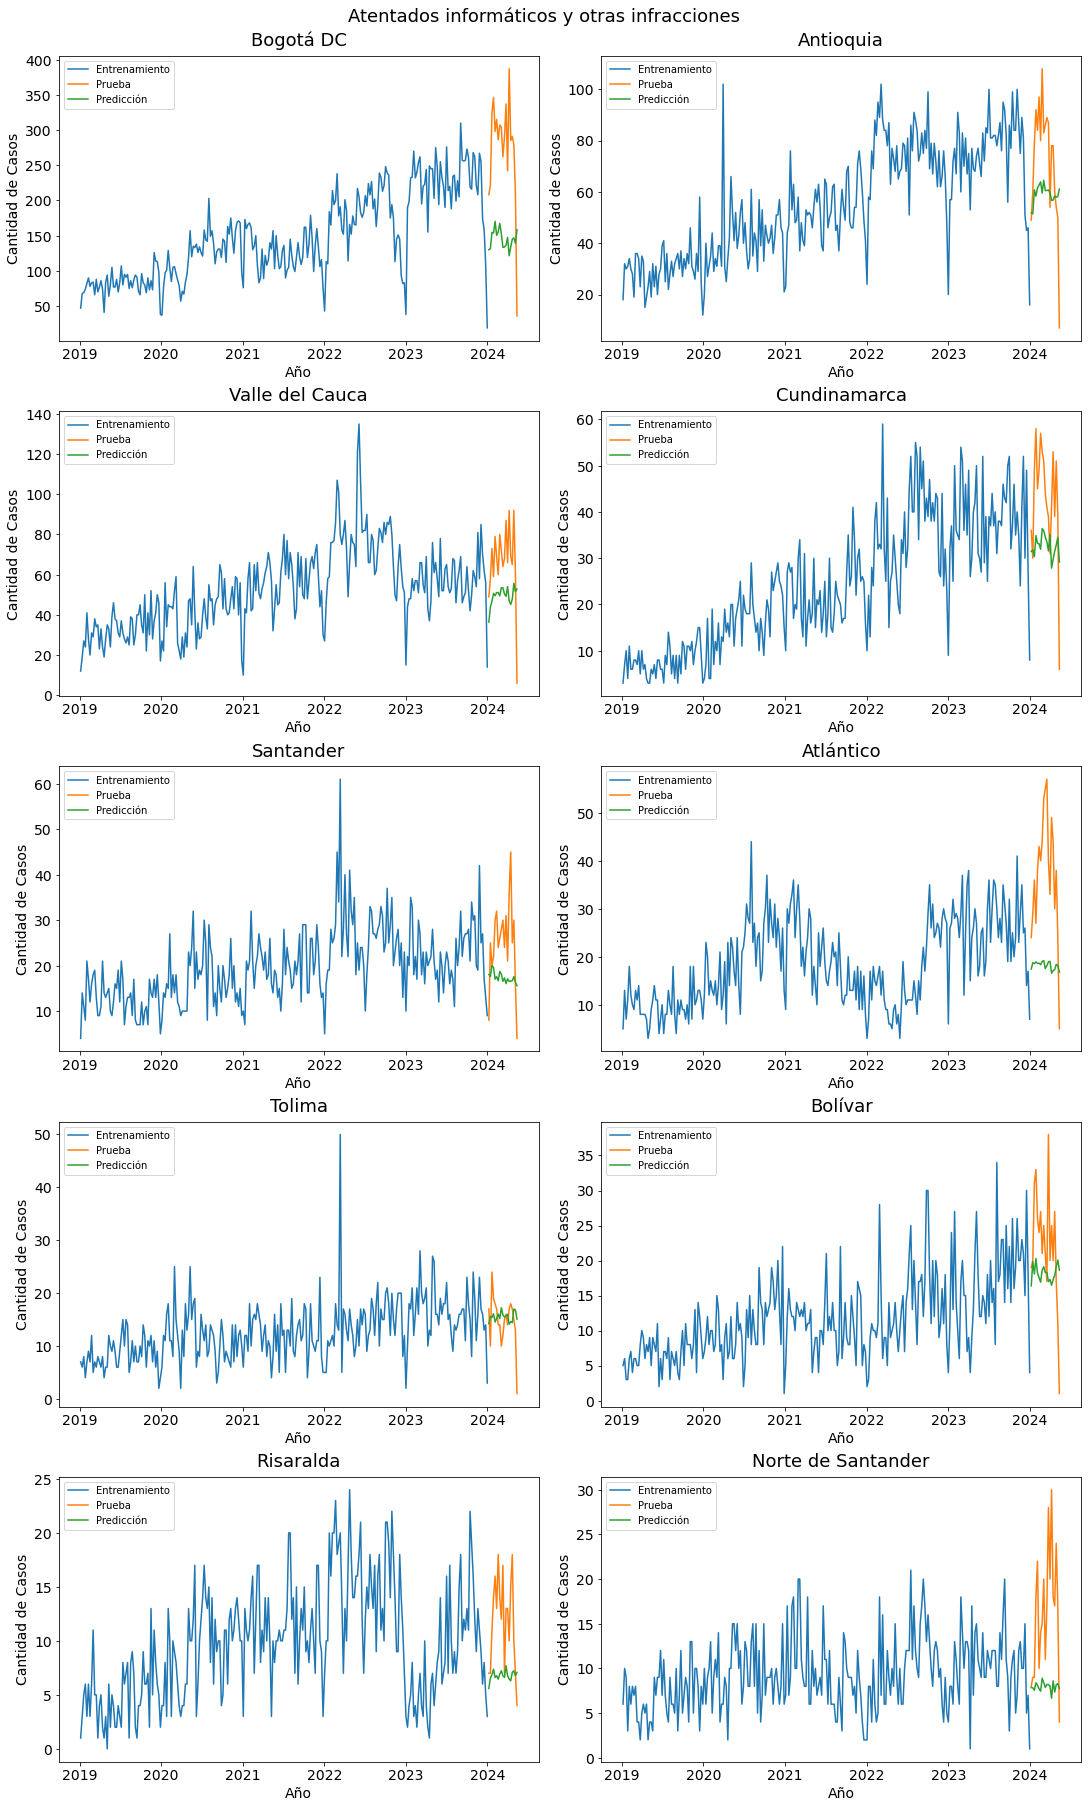

         Departamento  p-valor Test Statistic Critical Value (5%)  \
0           Bogotá DC  0.16932       -2.30824            -2.87308   
1           Antioquia  0.27450       -2.02785            -2.87299   
2     Valle del Cauca  0.38518       -1.79051            -2.87327   
3        Cundinamarca  0.31422       -1.93838            -2.87294   
4           Santander  0.00017       -4.53242            -2.87281   
5           Atlántico  0.35453       -1.85291            -2.87312   
6              Tolima  0.00000       -5.91916            -2.87281   
7             Bolívar  0.03841       -2.96386            -2.87294   
8           Risaralda  0.00977       -3.43681            -2.87290   
9  Norte de Santander  0.00003       -4.92051            -2.87285   

  Tipo de Serie Identificada                  Mejor Modelo  
0            No estacionaria  SARIMA(1, 0, 1)(1, 0, 1, 52)  
1            No estacionaria  SARIMA(0, 1, 1)(1, 0, 2, 52)  
2            No estacionaria  SARIMA(2, 0, 1)(1, 0, 0, 52

In [6]:
# Procesar datos de 'categoria_delito' = 1
df_filtered_1 = df[df['categoria_delito'] == 1]
process_category(df_filtered_1, 1, 'Atentados informáticos y otras infracciones', 'categoria_1')